(coherent-integration)=
# Coherent integration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

import sdr

%config InlineBackend.print_figure_kwargs = {"facecolor" : "w"}
%matplotlib inline
# %matplotlib widget

sdr.plot.use_style()
rng = np.random.default_rng(0)

In this example, we will detect two signals, $x_1[n]$ and $x_2[n]$.
The first signal $x_1[n]$ will be detected as is.
The second signal $x_2[n]$ will be coherently integrated and then detected.

We will show that $x_2[n]$ can have a lower SNR than $x_1[n]$ and achieve equivalent detection performance.
The SNR reduction equals the coherent integration gain $G_c$, as calculated by {func}`sdr.coherent_gain()`.

In [2]:
snr1 = 10
p_fa = 1e-3
n_c = 15
g_c = sdr.coherent_gain(n_c)
snr2 = snr1 - g_c

print(f"SNR 1: {snr1:.2f} dB")
print(f"Detection false alarm rate: {p_fa:1.2e}")
print(f"Coherently integrated samples: {n_c}")
print(f"Coherent gain: {g_c:.2f} dB")
print(f"SNR 2: {snr2:.2f} dB")

SNR 1: 10.00 dB
Detection false alarm rate: 1.00e-03
Coherently integrated samples: 15
Coherent gain: 11.76 dB
SNR 2: -1.76 dB


## Detect $x_1[n]$

The complex time-domain signal $x_1[n]$ is the sum of a phase-coherent signal and noise.

$$x_1[n] = s_1[n] + w_1[n]$$

The signal $s_1[n]$ has constant amplitude $A_1$.
The noise $w_1[n]$ is i.i.d. complex additive white Gaussian with variance $\sigma_1^2$.

$$s_1[n] = A_1$$
$$w_1[n] \sim \mathcal{CN}(0, \sigma_1^2)$$

In [3]:
def create_x(snr):
    sigma = 1  # Noise standard deviation, sigma
    A = np.sqrt(sdr.linear(snr) * sigma**2)  # Signal voltage, A

    N = 100_000
    s = A * np.ones(N)
    w = rng.normal(0, np.sqrt(sigma**2 / 2), N) + 1j * rng.normal(0, np.sqrt(sigma**2 / 2), N)
    x_h0 = w  # x under the H0 hypothesis
    x_h1 = s + w  # x under the H1 hypothesis

    return A, sigma, x_h0, x_h1

Generate the complex time-domain signal $x_1[n]$ with 10-dB SNR.

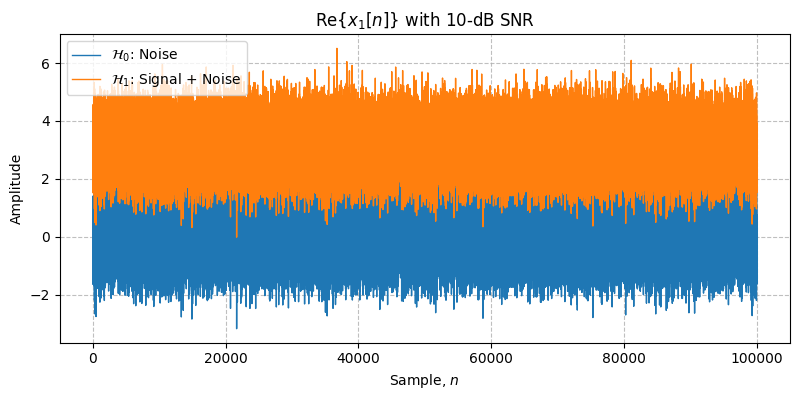

In [4]:
A1, sigma1, x1_h0, x1_h1 = create_x(snr1)

plt.figure()
sdr.plot.time_domain(x1_h0.real, label="$\mathcal{H}_0$: Noise")
sdr.plot.time_domain(x1_h1.real, label="$\mathcal{H}_1$: Signal + Noise")
plt.title(f"$\mathrm{{Re}}\{{x_1[n]\}}$ with {snr1}-dB SNR")
plt.show()

The signal $x_1[n]$ is distributed as follows.

$$
\begin{align}
    \mathcal{H}_0 &: x_1[n] \sim \mathcal{CN}(0, \sigma_1^2) \\
    \mathcal{H}_1 &: x_1[n] \sim \mathcal{CN}(A_1, \sigma_1^2)
\end{align}
$$

$\mathcal{H}_0$ is the null hypothesis.
It indicates the condition when only noise is present.
$\mathcal{H}_1$ is the alternative hypothesis.
It indicates the condition when signal and noise are present.

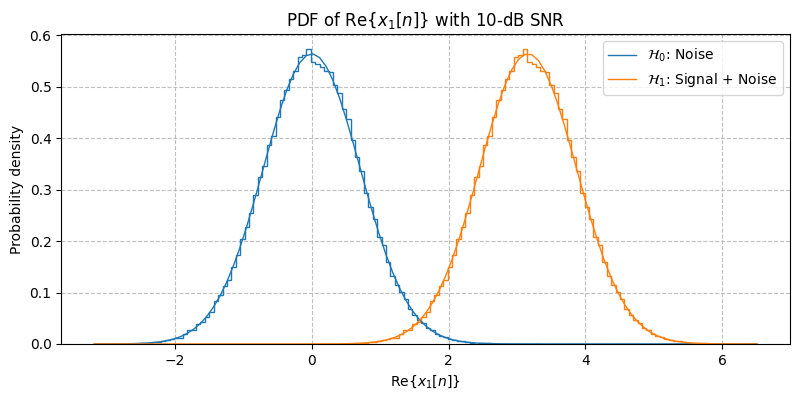

In [5]:
x1_h0_real_theory = scipy.stats.norm(0, np.sqrt(sigma1**2 / 2))
x1_h1_real_theory = scipy.stats.norm(A1, np.sqrt(sigma1**2 / 2))

plt.figure()
plt.hist(x1_h0.real, bins=101, histtype="step", density=True)
plt.hist(x1_h1.real, bins=101, histtype="step", density=True)
plt.gca().set_prop_cycle(None)
axis = np.linspace(min(x1_h0.real), max(x1_h1.real), 101)
plt.plot(axis, x1_h0_real_theory.pdf(axis), label="$\mathcal{H}_0$: Noise")
plt.plot(axis, x1_h1_real_theory.pdf(axis), label="$\mathcal{H}_1$: Signal + Noise")
plt.legend()
plt.xlabel("$\mathrm{Re}\{x_1[n]\}$")
plt.ylabel("Probability density")
plt.title(f"PDF of $\mathrm{{Re}}\{{x_1[n]\}}$ with {snr1}-dB SNR")
plt.show()

Determine the detection performance of $x_1[n]$.
If the absolute phase of $x_1[n]$ is unknown, which is common, the signal must be detected by examining the power of the signal $z_1[n]$.

$$z_1[n] = \left| x_1[n] \right|^2$$

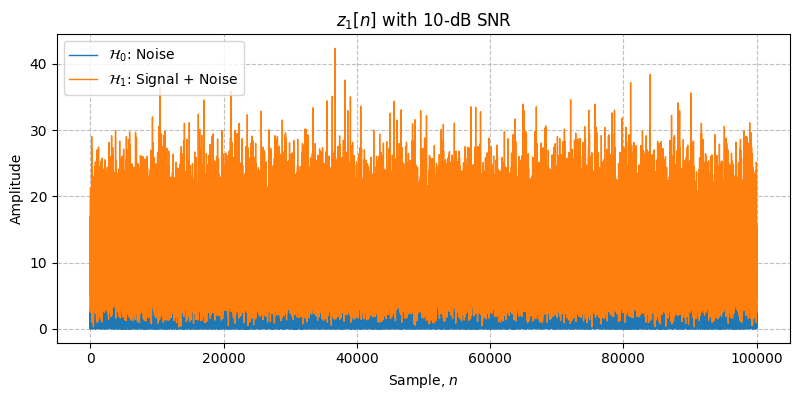

In [6]:
z1_h0 = np.abs(x1_h0) ** 2
z1_h1 = np.abs(x1_h1) ** 2

plt.figure()
sdr.plot.time_domain(z1_h0, label="$\mathcal{H}_0$: Noise")
sdr.plot.time_domain(z1_h1, label="$\mathcal{H}_1$: Signal + Noise")
plt.title(f"$z_1[n]$ with {snr1}-dB SNR")
plt.show()

The signal power $z_1[n]$ is distributed as follows.

$$
\begin{align}
    \mathcal{H}_0 &: z_1[n] \sim \chi_{\nu}^2 \\
    \mathcal{H}_1 &: z_1[n] \sim {\chi'}_{\nu}^2(\lambda)
\end{align}
$$

$\nu$ is the degrees of freedom and $\lambda$ is the non-centrality parameter.

$$\nu = 2$$
$$\lambda = \frac{A_1^2}{\sigma_1^2 / 2}$$

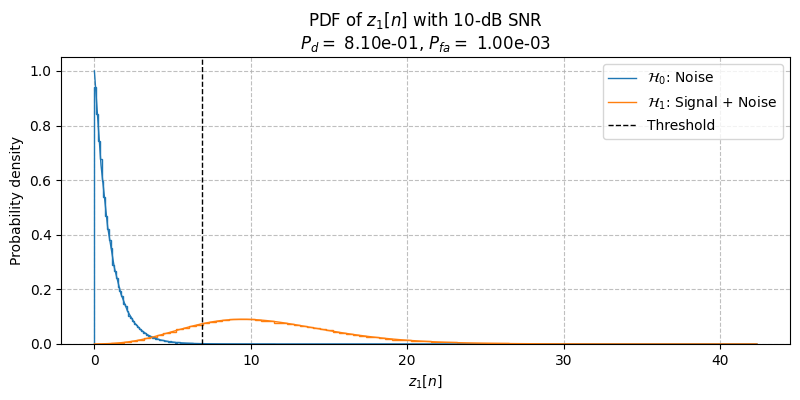

In [7]:
nu = 2  # Degrees of freedom
lambda_ = A1**2 / (sigma1**2 / 2)  # Non-centrality parameter
z1_h0_theory = scipy.stats.chi2(nu, scale=sigma1**2 / 2)
z1_h1_theory = scipy.stats.ncx2(nu, lambda_, scale=sigma1**2 / 2)

threshold = z1_h0_theory.isf(p_fa)
p_d = z1_h1_theory.sf(threshold)

plt.figure()
plt.hist(z1_h0, bins=101, histtype="step", density=True)
plt.hist(z1_h1, bins=101, histtype="step", density=True)
plt.gca().set_prop_cycle(None)
axis = np.linspace(min(z1_h0), max(z1_h1), 101)
plt.plot(axis, z1_h0_theory.pdf(axis), label="$\mathcal{H}_0$: Noise")
plt.plot(axis, z1_h1_theory.pdf(axis), label="$\mathcal{H}_1$: Signal + Noise")
plt.axvline(threshold, color="k", linestyle="--", label="Threshold")
plt.legend()
plt.xlabel("$z_1[n]$")
plt.ylabel("Probability density")
plt.title(f"PDF of $z_1[n]$ with {snr1}-dB SNR\n$P_d =$ {p_d:1.2e}, $P_{{fa}} =$ {p_fa:1.2e}")
plt.show()

Measure the probability of detection and probability of false alarm.
Compare the empirical results to theoretical.

In [8]:
p_d_meas = np.mean(z1_h1 > threshold)
print(f"Probability of detection: {p_d:1.2e} theory, {p_d_meas:1.2e} measured")

p_fa_meas = np.mean(z1_h0 > threshold)
print(f"Probability of false alarm: {p_fa:1.2e} theory, {p_fa_meas:1.2e} measured")

Probability of detection: 8.10e-01 theory, 8.11e-01 measured
Probability of false alarm: 1.00e-03 theory, 1.05e-03 measured


## Detect $x_2[n]$

Generate the complex time-domain signal $x_2[n]$ with -1.76-dB SNR.

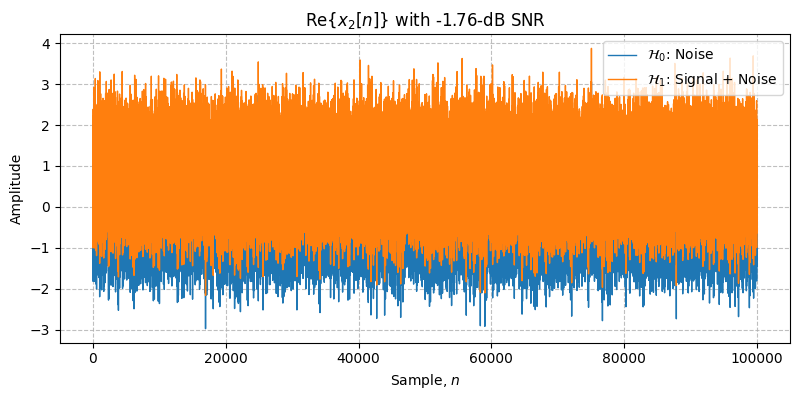

In [9]:
A2, sigma2, x2_h0, x2_h1 = create_x(snr2)

plt.figure()
sdr.plot.time_domain(x2_h0.real, label="$\mathcal{H}_0$: Noise")
sdr.plot.time_domain(x2_h1.real, label="$\mathcal{H}_1$: Signal + Noise")
plt.title(f"$\mathrm{{Re}}\{{x_2[n]\}}$ with {snr2:1.2f}-dB SNR")
plt.show()

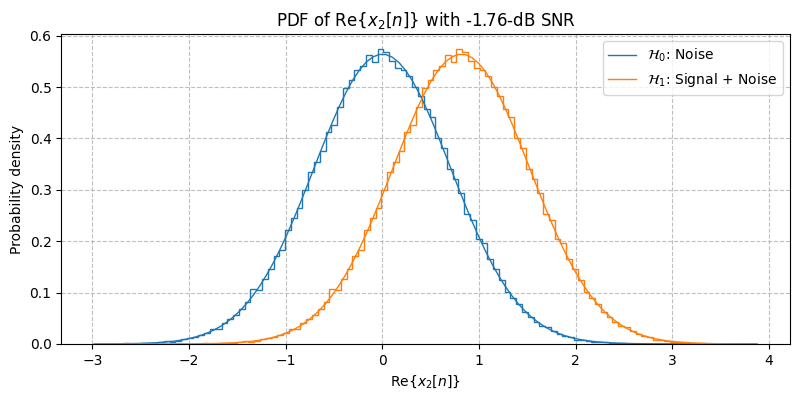

In [10]:
x2_h0_real_theory = scipy.stats.norm(0, np.sqrt(sigma2**2 / 2))
x2_h1_real_theory = scipy.stats.norm(A2, np.sqrt(sigma2**2 / 2))

plt.figure()
plt.hist(x2_h0.real, bins=101, histtype="step", density=True)
plt.hist(x2_h1.real, bins=101, histtype="step", density=True)
plt.gca().set_prop_cycle(None)
axis = np.linspace(min(x2_h0.real), max(x2_h1.real), 101)
plt.plot(axis, x2_h0_real_theory.pdf(axis), label="$\mathcal{H}_0$: Noise")
plt.plot(axis, x2_h1_real_theory.pdf(axis), label="$\mathcal{H}_1$: Signal + Noise")
plt.legend()
plt.xlabel("$\mathrm{Re}\{x_2[n]\}$")
plt.ylabel("Probability density")
plt.title(f"PDF of $\mathrm{{Re}}\{{x_2[n]\}}$ with {snr2:1.2f}-dB SNR")
plt.show()

Coherently integrate $N_C$ contiguous samples from the signal $x_2[n]$.

$$y_2[n] = \sum_{m=0}^{N_C-1} x_2[n -m]$$

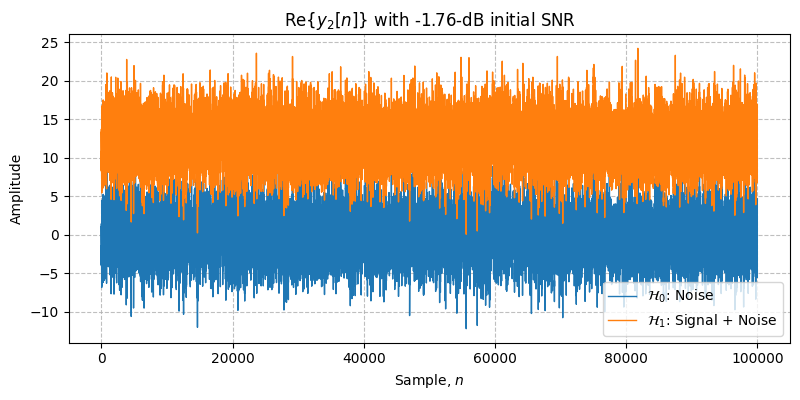

In [11]:
y2_h0 = np.sum(np.lib.stride_tricks.sliding_window_view(x2_h0, n_c), axis=-1)
y2_h1 = np.sum(np.lib.stride_tricks.sliding_window_view(x2_h1, n_c), axis=-1)

plt.figure()
sdr.plot.time_domain(y2_h0.real, label="$\mathcal{H}_0$: Noise")
sdr.plot.time_domain(y2_h1.real, label="$\mathcal{H}_1$: Signal + Noise")
plt.title(f"$\mathrm{{Re}}\{{y_2[n]\}}$ with {snr2:0.2f}-dB initial SNR")
plt.show()

The coherently integrated signal $y_2[n]$ is distributed as follows.

$$
\begin{align}
    \mathcal{H}_0 &: y_2[n] \sim \mathcal{CN}(0, N_C \sigma_2^2) \\
    \mathcal{H}_1 &: y_2[n] \sim \mathcal{CN}(N_C A_2, N_C \sigma_2^2)
\end{align}
$$

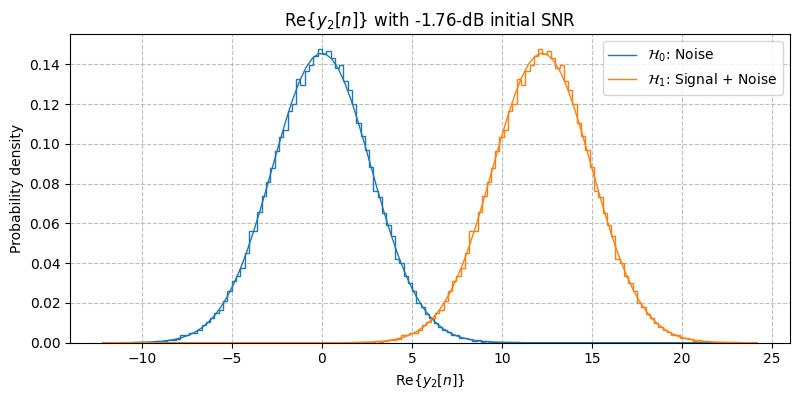

In [12]:
y2_h0_real_theory = scipy.stats.norm(0, np.sqrt(n_c * sigma2**2 / 2))
y2_h1_real_theory = scipy.stats.norm(n_c * A2, np.sqrt(n_c * sigma2**2 / 2))

plt.figure()
plt.hist(y2_h0.real, bins=101, histtype="step", density=True)
plt.hist(y2_h1.real, bins=101, histtype="step", density=True)
plt.gca().set_prop_cycle(None)
axis = np.linspace(min(y2_h0.real), max(y2_h1.real), 101)
plt.plot(axis, y2_h0_real_theory.pdf(axis), label="$\mathcal{H}_0$: Noise")
plt.plot(axis, y2_h1_real_theory.pdf(axis), label="$\mathcal{H}_1$: Signal + Noise")
plt.legend()
plt.xlabel("$\mathrm{Re}\{y_2[n]\}$")
plt.ylabel("Probability density")
plt.title(f"$\mathrm{{Re}}\{{y_2[n]\}}$ with {snr2:1.2f}-dB initial SNR")
plt.show()

Similarly, determine the detection performance of $y_2[n]$.
If the phase of $y_2[n]$ is unknown, the signal must be detected by examining the power of the signal $z_2[n]$.

$$z_2[n] = \left| y_2[n] \right|^2$$

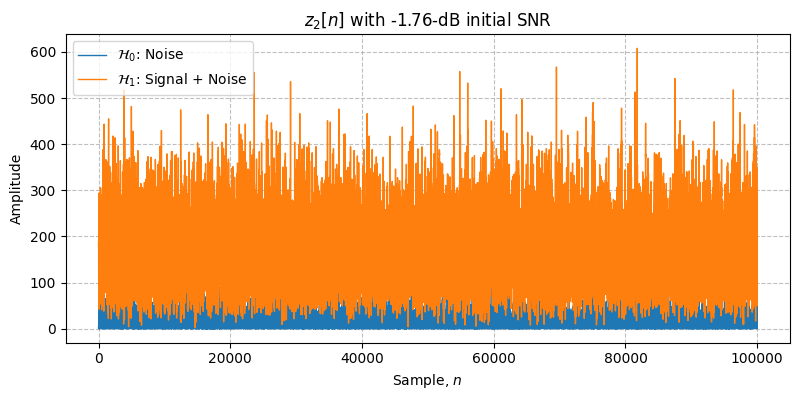

In [13]:
z2_h0 = np.abs(y2_h0) ** 2
z2_h1 = np.abs(y2_h1) ** 2

plt.figure()
sdr.plot.time_domain(z2_h0, label="$\mathcal{H}_0$: Noise")
sdr.plot.time_domain(z2_h1, label="$\mathcal{H}_1$: Signal + Noise")
plt.title(f"$z_2[n]$ with {snr2:1.2f}-dB initial SNR")
plt.show()

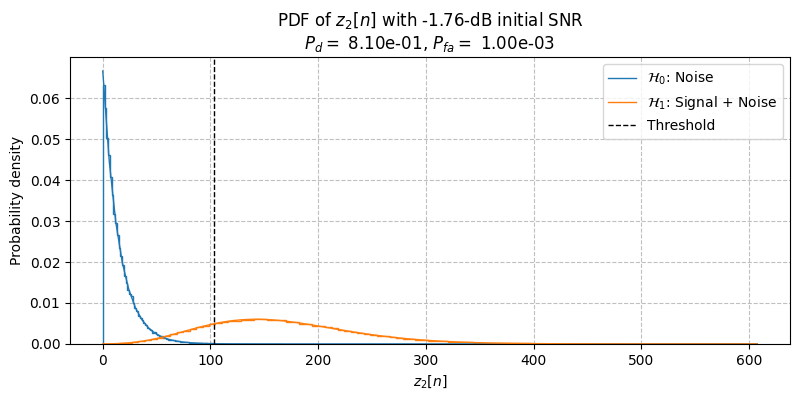

In [14]:
nu = 2  # Degrees of freedom
lambda_ = A2**2 * n_c / (sigma2**2 / 2)  # Non-centrality parameter
z2_h0_theory = scipy.stats.chi2(nu, scale=n_c * sigma2**2 / 2)
z2_h1_theory = scipy.stats.ncx2(nu, lambda_, scale=n_c * sigma2**2 / 2)

threshold = z2_h0_theory.isf(p_fa)
p_d = z2_h1_theory.sf(threshold)

plt.figure()
plt.hist(z2_h0, bins=101, histtype="step", density=True)
plt.hist(z2_h1, bins=101, histtype="step", density=True)
plt.gca().set_prop_cycle(None)
axis = np.linspace(min(z2_h0), max(z2_h1), 101)
plt.plot(axis, z2_h0_theory.pdf(axis), label="$\mathcal{H}_0$: Noise")
plt.plot(axis, z2_h1_theory.pdf(axis), label="$\mathcal{H}_1$: Signal + Noise")
plt.axvline(threshold, color="k", linestyle="--", label="Threshold")
plt.legend()
plt.xlabel("$z_2[n]$")
plt.ylabel("Probability density")
plt.title(f"PDF of $z_2[n]$ with {snr2:1.2f}-dB initial SNR\n$P_d =$ {p_d:1.2e}, $P_{{fa}} =$ {p_fa:1.2e}")
plt.show()

Measure the probability of detection and probability of false alarm.
Compare the empirical results to theoretical.

Notice that the detection performance of $x_1[n]$ and $x_2[n]$ are equivalent.

In [15]:
p_d_meas = np.mean(z2_h1 > threshold)
print(f"Probability of detection: {p_d:1.2e} theory, {p_d_meas:1.2e} measured")

p_fa_meas = np.mean(z2_h0 > threshold)
print(f"Probability of false alarm: {p_fa:1.2e} theory, {p_fa_meas:1.2e} measured")

Probability of detection: 8.10e-01 theory, 8.11e-01 measured
Probability of false alarm: 1.00e-03 theory, 1.05e-03 measured
